In [1]:
import findspark
findspark.init('/spark/')

In [2]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [3]:
sc = SparkContext()

In [4]:
ssc = StreamingContext(sc,10)
sqlcontext = SQLContext(sc)

In [5]:
socket_stream = ssc.socketTextStream("127.0.0.1",8889)

In [6]:
lines = socket_stream.window(20)

In [7]:
from collections import namedtuple
fields = ('tag','count')
Tweet = namedtuple('Tweet',fields)

In [8]:
lines.flatMap( lambda text: text.split(" ") ) \
.filter (lambda word: word.lower().startswith("#")) \
.map (lambda word: (word.lower(),1) ) \
.reduceByKey ( lambda a,b: a+b ) \
.map ( lambda rec: Tweet(rec[0],rec[1]) ) \
.foreachRDD ( lambda rdd: rdd.toDF().sort(desc('count'))
.limit(10).registerTempTable('tweets') )

In [16]:
ssc.start()

Py4JJavaError: An error occurred while calling o21.start.
: java.lang.IllegalStateException: StreamingContext has already been stopped
	at org.apache.spark.streaming.StreamingContext.start(StreamingContext.scala:608)
	at org.apache.spark.streaming.api.java.JavaStreamingContext.start(JavaStreamingContext.scala:556)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)


In [10]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

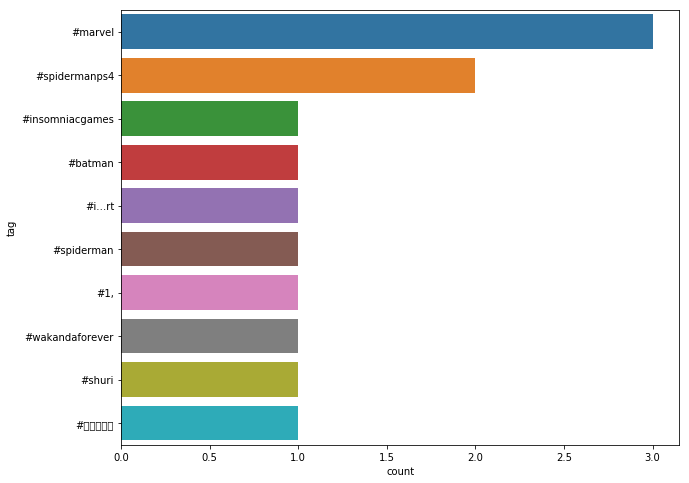

In [12]:
count = 0
while count < 10:
    time.sleep(3)
    top_10_tweets = sqlcontext.sql( 'Select tag,count from tweets' )
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = (10,8) )
    sns.barplot(x="count",y="tag", data=top_10_df)
    plt.show()
    count = count+1

In [15]:
ssc.stop()